In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
import collections

import pickle

%matplotlib inline
plt.style.use('seaborn-whitegrid')


path = 'data/'

# walk_file_name = 'walks-pro-x-pro-path-100-40-graphpattern2vec-biased-v2-rewire-merge_cc_train_while_loop_no_raise_all_pro'
# walk_file_name = 'walks-pro-x-pro-path-100-40-graphpattern2vec-biased-v3-realBiased'

In [16]:
class WalkAnalysis(object):
    
    def __init__(self, path, edge_file_name, walk_file_name):
        
        self.__merge_col_names = ['h','t','r', 'h_id', 't_id', 'r_id']
        
        self.__path = path
        self.__merge_file_name = edge_file_name
        self.__walk_file_name = walk_file_name
        
        self.__read_files()
        self.__get_node_groupby()
        self.__dict_from_walks()
        
        
    def analysis(self):
        d = self.__dict_wn
        t = self.__dict_t
        
        dk, dv = zip(*d.items())
        tk, tv = zip(*t.items())

        print('analysis| dk: {}, dv: {}'.format(len(dk), len(dv)))
        print('analysis| tk: {}, tv: {}'.format(len(tk), len(tv)))

        sq = list()
        for i in d:
            node   = i
            w_t_e  = t[i]
            w_cnt    = d[i]
            sq.append([node, w_t_e, w_cnt])
            
        print('analysis| seq: {}'.format(len(sq)))
        
        _, x, y = zip(*sq)
        _ = plt.scatter(x, y)
        plt.savefig(self.__path + 'dist_w_cnt_t_' + self.__walk_file_name + '.png')
        
    
    def __draw_hist(self, a, bins='auto'):
        print('min: {}, max: {}'.format(np.min(a), np.max(a)))
        _ = plt.hist(a, bins=bins)  # arguments are passed to np.histogram
        plt.title("Histogram with 'auto' bins")

        plt.show()
        
    def __get_node_groupby(self):
        cols = self.__merge_col_names
        df_m = self.__df_merge
        
        df_g_h_r = df_m.groupby([cols[3], cols[5]])[cols[4]].count().reset_index(name = cols[2] + '_count')
        df_g_t_r = df_m.groupby([cols[4], cols[5]])[cols[3]].count().reset_index(name = cols[1] + '_count')
        print('__get_node_groupby| df_g_h_r: {}, df_g_t_r: {}'.format(df_g_h_r.shape, df_g_t_r.shape))

        dict_t = dict()
        for i in df_g_h_r.itertuples():
            h_id  = i[1]
            r_id  = i[2]
            count = i[3]

            if h_id not in dict_t:
                dict_t[h_id] = 0
            dict_t[h_id] += count


        print('__get_node_groupby| dict_t after first columns: {}'.format(len(dict_t)))
        for i in df_g_t_r.itertuples():
            t_id  = i[1]
            r_id  = i[2]
            count = i[3]

            if t_id not in dict_t:
                dict_t[t_id] = 0
            dict_t[t_id] += count


        print('__get_node_groupby| dict_t after second columns: {}'.format(len(dict_t)))

        self.__dict_t = dict_t
        
    def __read_files(self):
        mcols = self.__merge_col_names
        
        self.__df_merge = pd.read_csv(self.__path + self.__merge_file_name + '.csv'
                                      , dtype={mcols[0]: object, mcols[1]: object, mcols[2]:object, mcols[3]:int
                                               , mcols[4]:int, mcols[5]:int})
        print('__read_processed_files| df_merge: {}'.format(self.__df_merge.shape))
        
    def __dict_from_walks(self):
        tok_count = 0
        set_line_len = set()
        dict_line_len = dict()
        dict_wn = dict()
        for line in tqdm(open(self.__path + self.__walk_file_name, 'r')):
            w = line.strip().split(' ')
            w = np.array(w, dtype=object)
            
            if len(w) not in dict_line_len:
                dict_line_len[len(w)] = 0
            dict_line_len[len(w)] += 1
            
            set_line_len.add(len(w))
            for i in w:
                identifier = int(i[1:])
                if identifier not in dict_wn:
                    dict_wn[identifier] = 0
                dict_wn[identifier]+=1
                tok_count+=1
        self.__dict_wn = dict_wn
        print('__dict_from_walks| __dict_from_walks: {}'.format(len(self.__dict_wn)))
        print('__dict_from_walks| token count: {}'.format(tok_count))
        self.set_line_len = set_line_len
        self.dict_line_len = dict_line_len
        
    def dict_lenght_walks(self):
        dict_wn = dict()
        lenght_walks = dict()
        for line in tqdm(open(self.__path + self.__walk_file_name, 'r')):
            w = line.strip().split(' ')
            if len(w) not in lenght_walks:
                lenght_walks[len(w)] = 0
            lenght_walks[len(w)] += 1
        return lenght_walks
    
    
                
    def get__dict_wn(self):
        return self.__dict_wn
    
    def get__dict_t(self):
        return self.__dict_t
    

# Process

In [38]:
def process(walk_file_name):
    wa = WalkAnalysis(path, 'df_merge_cc_train', walk_file_name)
    d = wa.dict_line_len
    d = collections.OrderedDict(sorted(d.items()))
    total = sum(list(d.values()))
    print('total: {}'.format(total))
    
    fig = plt.figure(figsize = (7,7))
    x, y = d.keys(), np.array(list(d.values()))/total
    plt.scatter(x, y)
    
    plt.savefig(path + 'len_hist_' + walk_file_name)
    plt.show()
    
    return wa

In [39]:
def load_node_to_class(data_path, node_to_class_file):
    with open(data_path + node_to_class_file + '.pkl', 'rb') as f:
        d_node_to_class = pickle.load(f)
    print('load_node_to_class| __d_node_to_class: {}'.format(len(d_node_to_class)))
    return d_node_to_class

In [40]:
def generate_class_count(wa, d_n_c):
    d_class_count = dict()
    for i in d_n_c.values():
        if i not in d_class_count:
            d_class_count[i] = 0
        d_class_count[i]+=1
    d_class_count
    a,b = np.array(list(d_class_count.keys())), np.array(list(d_class_count.values()))
    perc_class_count = tuple(zip(a, b/sum(b)*100))
    
    d_node_wn = wa.get__dict_wn()
    
    err_c = 0
    d_class_walks = dict()
    for i in d_n_c:
        c = d_n_c[i]
        if c not in d_class_walks:
            d_class_walks[c] = 0
        try:
            wn = d_node_wn[i]
            d_class_walks[c] += wn
        except KeyError:
            err_c += 1
    print(len(d_class_walks), err_c)
    
    a,b = np.array(list(d_class_walks.keys())), np.array(list(d_class_walks.values()))
    perc_class_wn = tuple(zip(a, b/sum(b)*100))
    print(perc_class_wn)
    
    return perc_class_wn

def plot_scatter_class_count(class_counts, full_file_path):
    fig = plt.figure(figsize = (7,7))
    x, y = zip(*class_counts)
    plt.scatter(x, y)
    plt.savefig(full_file_path)
    plt.show()
    

#### biased-v4_BP1-CC1-MF2

__read_processed_files| df_merge: (2851116, 6)
__get_node_groupby| df_g_h_r: (466654, 3), df_g_t_r: (53540, 3)


4930it [00:00, 49298.75it/s]

__get_node_groupby| dict_t after first columns: 178320
__get_node_groupby| dict_t after second columns: 212557


6786400it [02:22, 47519.22it/s]


__dict_from_walks| __dict_from_walks: 192932
__dict_from_walks| token count: 272910185
total: 6786400


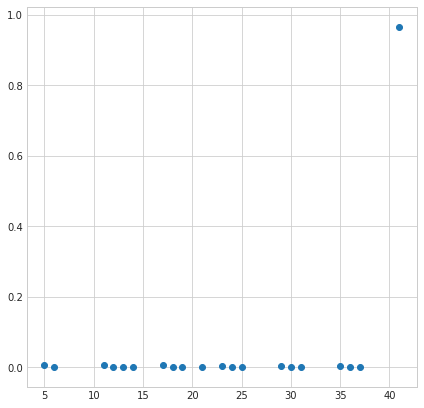

load_node_to_class| __d_node_to_class: 212557
7 19625
(('Protein', 51.58191146292324), ('BP', 14.249408463813836), ('MF', 8.770615138456632), ('CC', 3.53693871850184), ('Pathway', 16.96692301901448), ('FD', 4.864900516629675), ('PTM', 0.02930268066030588))


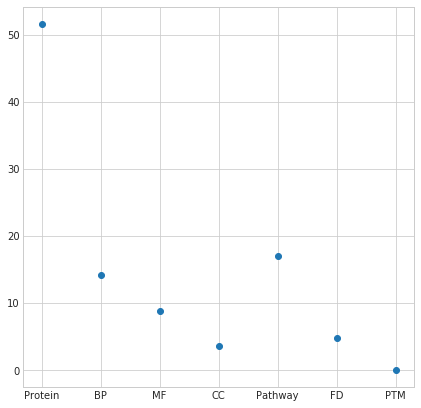

In [41]:
walk_file_name = 'walks-pro-x-pro-path-40-40-graphpattern2vec-40-40-biased-v4_BP1-CC1-MF2'
wa = process(walk_file_name)

d_n_c = load_node_to_class('data/', 'dict_node_to_class')
class_counts = generate_class_count(wa, d_n_c)
plot_scatter_class_count(class_counts, path + 'class_count_hist_' + walk_file_name)

## biased-v3-realBiased

In [3]:
wa = WalkAnalysis(path, 'df_merge_cc_train', walk_file_name)

__read_processed_files| df_merge: (2851116, 6)
__get_node_groupby| df_g_h_r: (466654, 3), df_g_t_r: (53540, 3)


4854it [00:00, 48533.45it/s]

__get_node_groupby| dict_t after first columns: 178320
__get_node_groupby| dict_t after second columns: 212557


16966000it [06:07, 46212.39it/s]

__dict_from_walks| __dict_from_walks: 196430
__dict_from_walks| token count: 639871573


In [4]:
d = wa.dict_line_len
d = collections.OrderedDict(sorted(d.items()))
d # total 177899


OrderedDict([(5, 476435),
             (6, 30216),
             (7, 1716),
             (8, 1041),
             (9, 148),
             (10, 45),
             (11, 422787),
             (12, 24956),
             (13, 2365),
             (14, 1310),
             (15, 237),
             (16, 107),
             (17, 391345),
             (18, 23444),
             (19, 2887),
             (20, 1350),
             (21, 1594),
             (22, 153),
             (23, 369889),
             (24, 24007),
             (25, 3280),
             (26, 1535),
             (27, 345),
             (28, 152),
             (29, 351052),
             (30, 24309),
             (31, 4253),
             (32, 1629),
             (33, 399),
             (34, 178),
             (35, 335745),
             (36, 24665),
             (37, 4077),
             (38, 1751),
             (39, 419),
             (40, 197),
             (41, 14435982)])

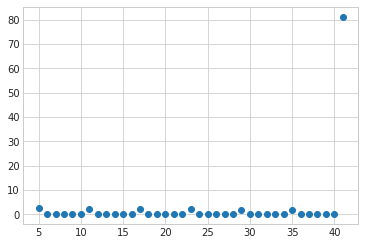

In [5]:
total = 177899
x, y = d.keys(), np.array(list(d.values()))/total
plt.scatter(x, y)
plt.show()

# Analysis of class of entities 

In [6]:
def load_node_to_class(data_path, node_to_class_file):
    with open(data_path + node_to_class_file + '.pkl', 'rb') as f:
        d_node_to_class = pickle.load(f)
    print('load_node_to_class| __d_node_to_class: {}'.format(len(d_node_to_class)))
    return d_node_to_class

In [7]:
d_n_c = load_node_to_class('data/', 'dict_node_to_class')

load_node_to_class| __d_node_to_class: 212557


In [11]:
def generate_class_count(wa):
    d_class_count = dict()
    for i in d_n_c.values():
        if i not in d_class_count:
            d_class_count[i] = 0
        d_class_count[i]+=1
    d_class_count
    a,b = np.array(list(d_class_count.keys())), np.array(list(d_class_count.values()))
    perc_class_count = tuple(zip(a, b/sum(b)*100))
    
    d_node_wn = wa.get__dict_wn()
    
    err_c = 0
    d_class_walks = dict()
    for i in d_n_c:
        c = d_n_c[i]
        if c not in d_class_walks:
            d_class_walks[c] = 0
        try:
            wn = d_node_wn[i]
            d_class_walks[c] += wn
        except KeyError:
            err_c += 1
    print(len(d_class_walks), err_c)
    
    a,b = np.array(list(d_class_walks.keys())), np.array(list(d_class_walks.values()))
    perc_class_wn = tuple(zip(a, b/sum(b)*100))
    print(perc_class_wn)
    
    return perc_class_wn

In [12]:
class_counts = generate_class_count(wa)

7 23200
(('Protein', 84.63962929149805), ('BP', 7.869821298509894), ('MF', 2.2298986495705777), ('CC', 1.1058669352723824), ('Pathway', 0.6405816754896275), ('FD', 3.1949183615388748), ('PTM', 0.3192837881205865))


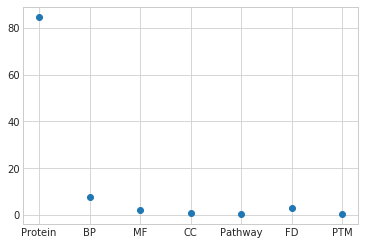

In [14]:
x, y = zip(*class_counts)
plt.scatter(x, y)
plt.show()

# From Real Biased

In [ ]:
walk_file_name = 'walks-pro-x-pro-path-100-40-graphpattern2vec-biased-v3-realBiased'
wa_b = WalkAnalysis(path, 'df_merge_cc_train', walk_file_name)

In [ ]:
d_b = wa_b.dict_line_len
d_b = collections.OrderedDict(sorted(d.items()))
d_b

In [ ]:
d_n_c = generate_node_to_class_dict(df_merge)
len(d_n_c)

In [ ]:
generate_class_count(wa_b)

## Experiment of effect of Walk Length and number of walks on Discovery Nodes 
##### FOR ALL: wc -l df_nodes_cc.csv -> 212558 - 1 and  in prepare_filter_only_connected_component| df_nodes_cc: (212557, 2)
##### Comparing to experiment from _same_run11 with settings 100,40:
      size of emb: 196431, count line: 196431, list chk: 196431
      - dict_t after second ..-> 212557

- Experiment setting: 150, 40 seed = 2 
  - wc -l walks...        -> 25,449,000
  - __dict_from_walks| __dict_from_walks: 196430
- Experiment setting: 100, 80, seed = 2
  - file name : walks-pro-x-pro-path-100-80-graphpattern2vec-biased-v2-rewire-merge_cc_train_walklen
  - wc -l walks...        -> 16,966,000
  - __dict_from_walks: 196430
- Experiment setting: 100, 40, seed = 71
  - file name : walks-pro-x-pro-path-100-40-graphpattern2vec-biased-v2-rewire-merge_cc_train_seed71
  - wc -l walks...       -> 16,966,000
  - __dict_from_walks: 196430
- Experiment setting: 40, 40, seed = 2
  - file name : walks-pro-x-pro-path-40-40-graphpattern2vec-biased-v2-rewire-merge_cc_train_numwalks
  - wc -l walks...       -> 6,786,400 (pro_other: 169660 * numwalks = 40 )
  - __dict_from_walks: 196430
- Experiment setting: 1, 10, seed = 20
  - file name : walks-pro-x-pro-path-1-10-graphpattern2vec-biased-v2-rewire-merge_cc_train_small
  - wc -l walks...      -> 169660
  - __dict_from_walks: 194253
- Experiment setting: 1, 5, seed = 20
  - file name: walks-pro-x-pro-path-1-5-graphpattern2vec-biased-v2-rewire-merge_cc_train_small
  - wc -l walks...      -> 169660
  - __dict_from_walks: 191781
  
- Experiment setting: 1, 5, seed = 20 <b>With WHILE LOOP</b>
  - file name: walks-pro-x-pro-path-1-5-graphpattern2vec-biased-v2-rewire-merge_cc_train_while_loop
  - wc -l walks...      -> 169660
  - __dict_from_walks: 191332
- Experiment setting: 1, 10, seed = 20 <b>With WHILE LOOP</b>
  - file name : walks-pro-x-pro-path-1-10-graphpattern2vec-biased-v2-rewire-merge_cc_train_while_loop
  - wc -l walks...      -> 169660
  - __dict_from_walks: 193557